Перед тобой датасет некой интернет-компании.

a. Какой рекламный канал принёс больше всего дохода за всё время?

b. Как изменился средний чек транзакции после введения коронавирусных ограничений?
Как он изменился для пользователей, покупающих с промокодом и без? (параметр
«promo_activated»)

c. Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в
транзакцию) в выходные дни отличается от CR в будние дни?

d. Вам необходимо спрогнозировать объем дохода, полученного с пользователей,
приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед.
Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам
понадобятся?

e. Если ты нашел что-то еще интересное в данных, то тоже пиши ;)

In [86]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import holidays
import datetime
from scipy.stats import ttest_ind
import scipy.stats as ss
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose 

In [2]:
df = pd.read_csv('summer_camp_data.csv')
df.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0


**date** - дата

**source** - источник трафика

**medium** - канал

**delivery_available** - доступность доставка

**device_type** - тип устройства

**promo_activated** - активный промо

**filter_used** - использование фильтра

**pageviews** - просмотры страницы

**visits** - визиты

**productClick** - клики

**addToCart** - добавление в корзину

**checkout** - оформление заказа

**transactions** - транзакции

**revenue** - доход

In [3]:
df.describe()

,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
count,52721.000000,52721.000000,52721.000000,52721.000000,52721.000000,52721.000000,5.272100e+04
mean,445.620417,127.120844,890.756245,177.974659,146.557615,20.086436,2.419143e+04
std,1108.398930,384.872452,2100.555207,419.898507,344.635930,52.430012,6.381563e+04
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,12.000000,2.000000,20.000000,4.000000,3.000000,0.000000,0.000000e+00
50%,47.000000,7.000000,90.000000,18.000000,15.000000,2.000000,2.445000e+03
75%,256.000000,41.000000,520.000000,104.000000,83.000000,11.000000,1.329400e+04
max,26589.000000,6975.000000,32460.000000,6486.000000,3857.000000,1113.000000,1.397420e+06


In [4]:
df.dtypes

date                   object
source                 object
medium                 object
delivery_available     object
device_type            object
promo_activated        object
filter_used            object
pageviews               int64
visits                  int64
productClick            int64
addToCart               int64
checkout                int64
transactions            int64
revenue               float64
dtype: object

In [5]:
df.isna().sum()

date                  0
source                0
medium                0
delivery_available    0
device_type           0
promo_activated       0
filter_used           0
pageviews             0
visits                0
productClick          0
addToCart             0
checkout              0
transactions          0
revenue               0
dtype: int64

In [6]:
# поменяем тип данных

df['date'] = df['date'].astype('datetime64')

In [7]:
df.dtypes

date                  datetime64[ns]
source                        object
medium                        object
delivery_available            object
device_type                   object
promo_activated               object
filter_used                   object
pageviews                      int64
visits                         int64
productClick                   int64
addToCart                      int64
checkout                       int64
transactions                   int64
revenue                      float64
dtype: object

### a. Какой рекламный канал принёс больше всего дохода за всё время?

In [8]:
# количество уникальных рекламных каналов

df.medium.nunique()

6

In [9]:
# уникальные рекламные каналы

df.medium.unique()

array(['organic', 'cpc', '(none)', 'cpa', 'email', 'social'], dtype=object)

**organic** - обычный поиск

**cpc** - Pay-Per-Click оплата за клик (платная поиск)

**(none)** - прямой трафик

**cpa** - Cost-Per-Action оплата за действие (платный поиск)

**email** - переходы по ссылкам из писем

**social** - трафик из социальных сетей о которых известно Google

In [10]:
# количество рекламных каналов

df.medium.value_counts()

cpc        16833
organic    15520
cpa         8927
(none)      5031
email       3998
social      2412
Name: medium, dtype: int64

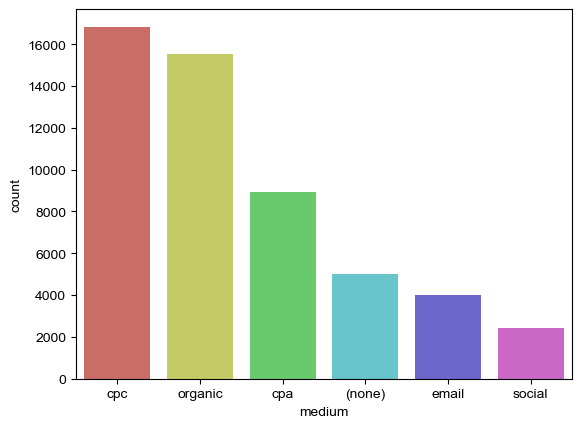

In [11]:
sns.countplot(x='medium', data=df, order = df['medium'].value_counts().index, palette='hls')
sns.set(rc={'figure.figsize':(20,10)})

In [12]:
# сумма дохода по каналам

df_revenue = df.groupby('medium').agg({'revenue' : 'sum'}).sort_values('revenue', ascending=False).reset_index()
df_revenue

,medium,revenue
0,organic,4.984552e+08
1,cpc,4.448376e+08
2,(none),2.383551e+08
3,cpa,8.183424e+07
4,email,1.100086e+07
5,social,9.136260e+05


In [13]:
#pd.options.display.float_format ='{:,.2f}'.format

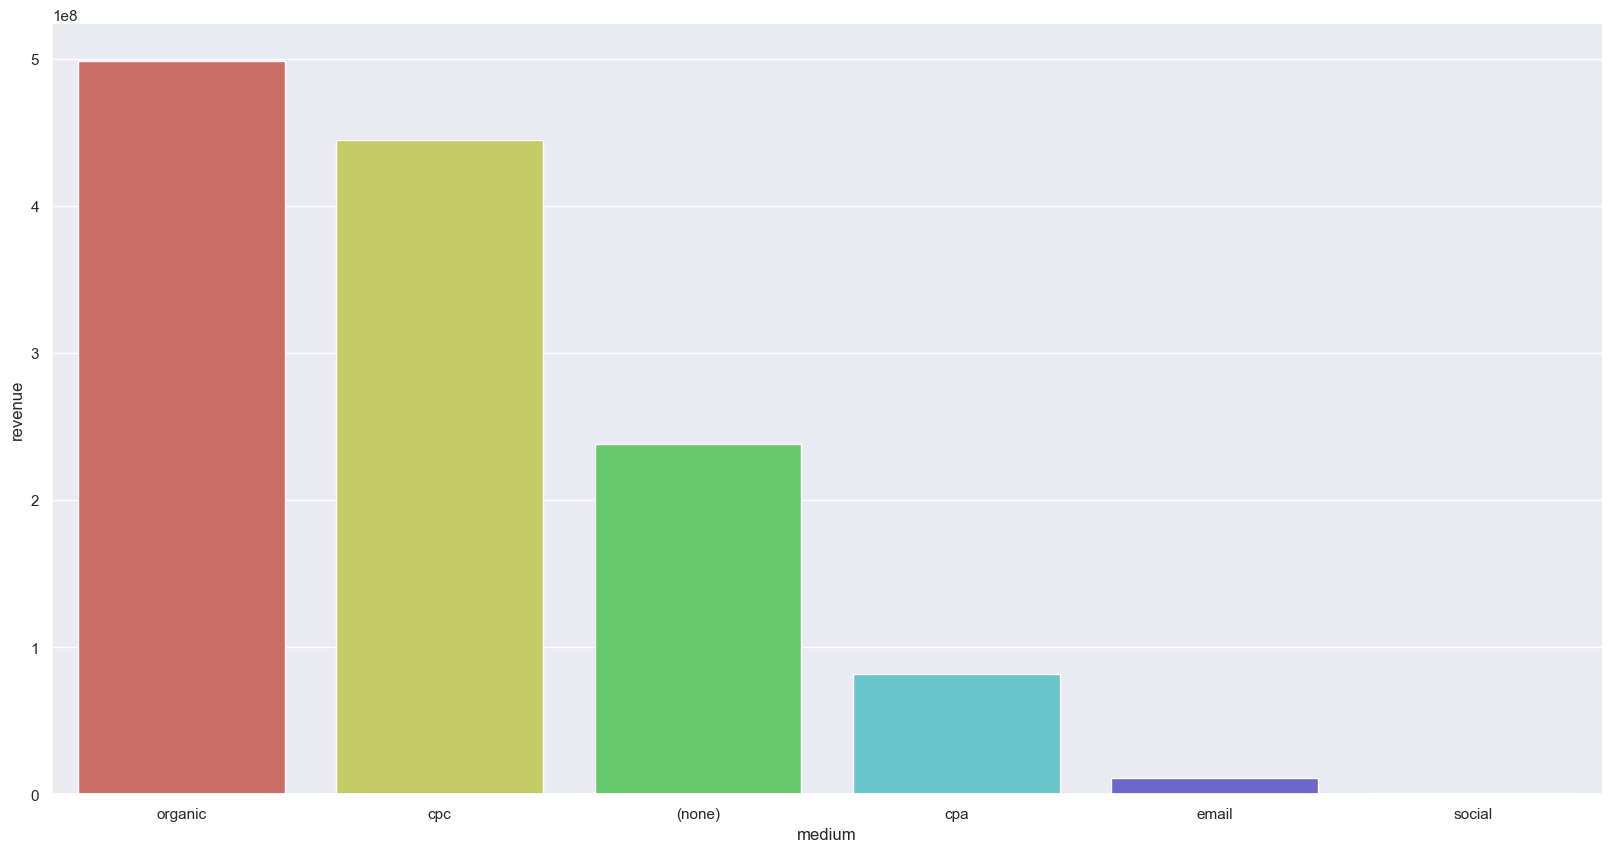

In [14]:
# сумма дохода по каналам

sns.barplot(x=df_revenue['medium'],y=df_revenue['revenue'],data=df_revenue,palette='hls')
sns.despine()
sns.set(rc={'figure.figsize':(20,10)})

ОТВЕТ:

Рекламный канал organic (обычный поиск) принёс больше всего дохода за всё время - 498,455,154 руб.

### b. Как изменился средний чек транзакции после введения коронавирусных ограничений? 
### Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

In [15]:
df_2 = df[['source', 'date', 'promo_activated', 'transactions', 'revenue']]
df_2

,source,date,promo_activated,transactions,revenue
0,google,2020-05-11,no,90,86649.0
1,yandex,2020-05-11,yes,217,244478.0
2,google,2020-05-11,no,100,105150.0
3,google,2020-05-11,no,71,79003.0
4,yandex,2020-05-11,no,62,61861.0
...,...,...,...,...,...
52716,(direct),2020-06-21,yes,4,4821.0
52717,co-promo,2020-08-09,no,1,7348.0
52718,google,2020-09-22,yes,1,958.0
52719,(direct),2020-08-25,yes,1,828.0


In [16]:
df_2.isna().sum()

source             0
date               0
promo_activated    0
transactions       0
revenue            0
dtype: int64

In [17]:
df_2.dtypes

source                     object
date               datetime64[ns]
promo_activated            object
transactions                int64
revenue                   float64
dtype: object

In [18]:
# средний чек  по кампании = доход / кол-во транзакций

df_2['avg_check'] = df_2.revenue / df_2.transactions
df_2.head()

C:\Users\Марина\AppData\Local\Temp\ipykernel_9592\3641875273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['avg_check'] = df_2.revenue / df_2.transactions


,source,date,promo_activated,transactions,revenue,avg_check
0,google,2020-05-11,no,90,86649.0,962.766667
1,yandex,2020-05-11,yes,217,244478.0,1126.626728
2,google,2020-05-11,no,100,105150.0,1051.500000
3,google,2020-05-11,no,71,79003.0,1112.718310
4,yandex,2020-05-11,no,62,61861.0,997.758065


In [19]:
df_2.describe()

,transactions,revenue,avg_check
count,52721.000000,5.272100e+04,38450.000000
mean,20.086436,2.419143e+04,1219.605578
std,52.430012,6.381563e+04,1030.907320
min,0.000000,0.000000e+00,0.000000
25%,0.000000,0.000000e+00,975.136288
50%,2.000000,2.445000e+03,1138.000000
75%,11.000000,1.329400e+04,1329.653893
max,1113.000000,1.397420e+06,157370.375000


In [20]:
# сортировка по сумме среднего чека

df_2.sort_values('avg_check', ascending=False)

,source,date,promo_activated,transactions,revenue,avg_check
17144,(direct),2020-03-26,no,8,1258963.0,157370.375000
15159,google,2020-04-17,no,6,349088.0,58181.333333
17377,DuckDuckGo,2020-03-06,no,1,43956.0,43956.000000
12434,google,2020-04-17,no,5,206433.0,41286.600000
17589,yandex,2020-03-05,no,2,36267.0,18133.500000
...,...,...,...,...,...,...
52429,(direct),2020-06-02,yes,0,0.0,NaN
52434,facebook,2020-06-17,yes,0,0.0,NaN
52467,facebook,2020-02-02,no,0,0.0,NaN
52514,(direct),2020-09-01,yes,0,0.0,NaN


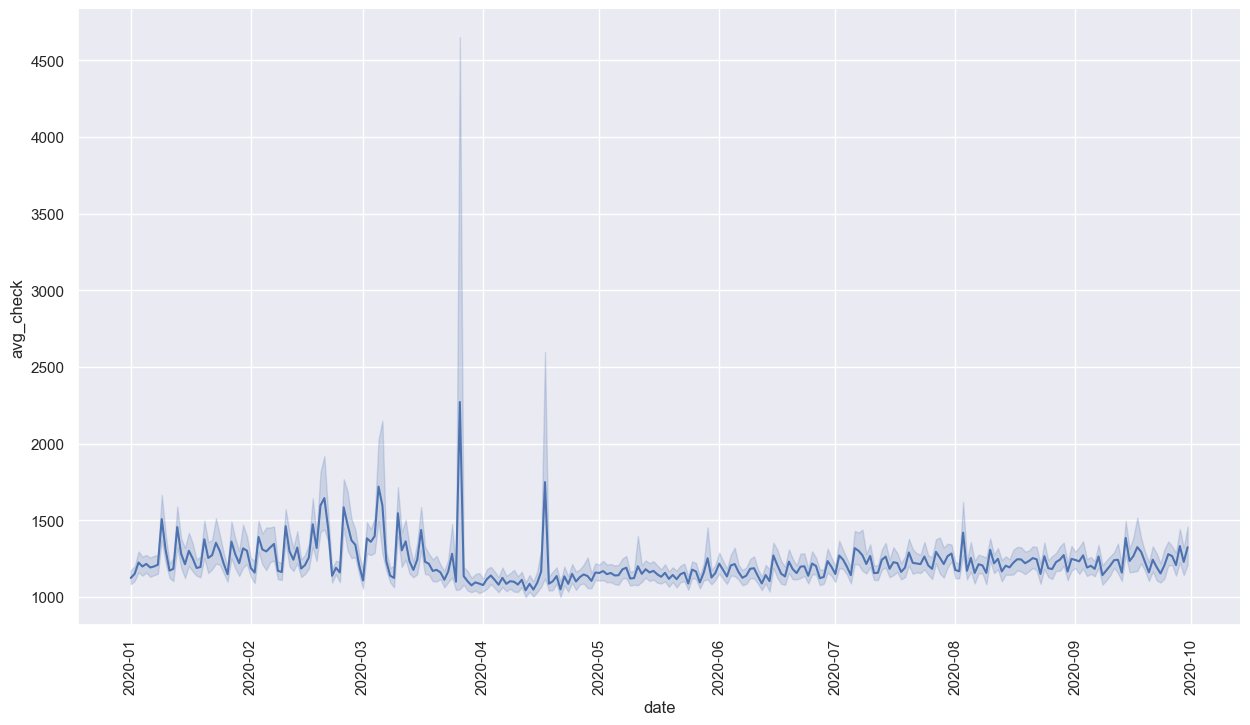

In [21]:
# построим график lineplot

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_2)
sns.despine()

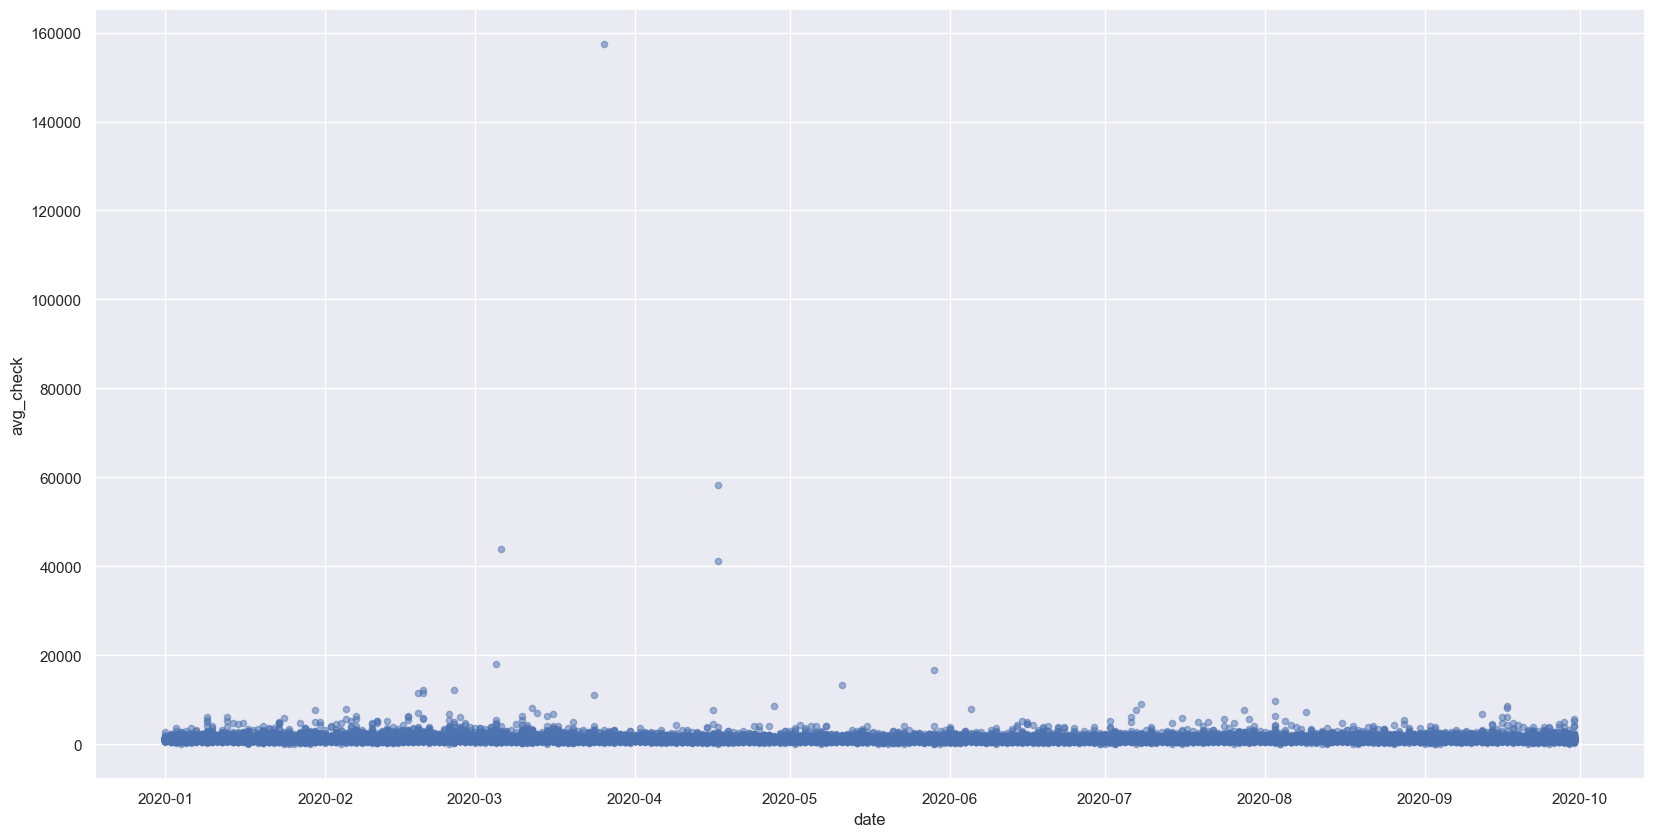

In [22]:
# посмотрим где есть выбросы

df_2.plot.scatter(x="date", y="avg_check", alpha=0.5);

По графикам заметно, что изменения по сравнению с остальными периодами начались примерно в марте-апреле 2020, что совпало с короновирусными ограничениями.

Рассмотрим март и апрель 2020 более подробно.

In [23]:
# фильтруем по дате

df_march_april = df_2.query("date >= '2020-03-01' and date < '2020-04-30'")
df_march_april.head()

,source,date,promo_activated,transactions,revenue,avg_check
12,(direct),2020-03-26,yes,14,14488.0,1034.857143
13,(direct),2020-03-26,yes,95,97904.0,1030.568421
14,(direct),2020-03-26,no,37,34204.0,924.432432
15,google,2020-03-26,yes,278,266796.0,959.697842
16,admitad,2020-03-26,yes,39,37693.0,966.487179


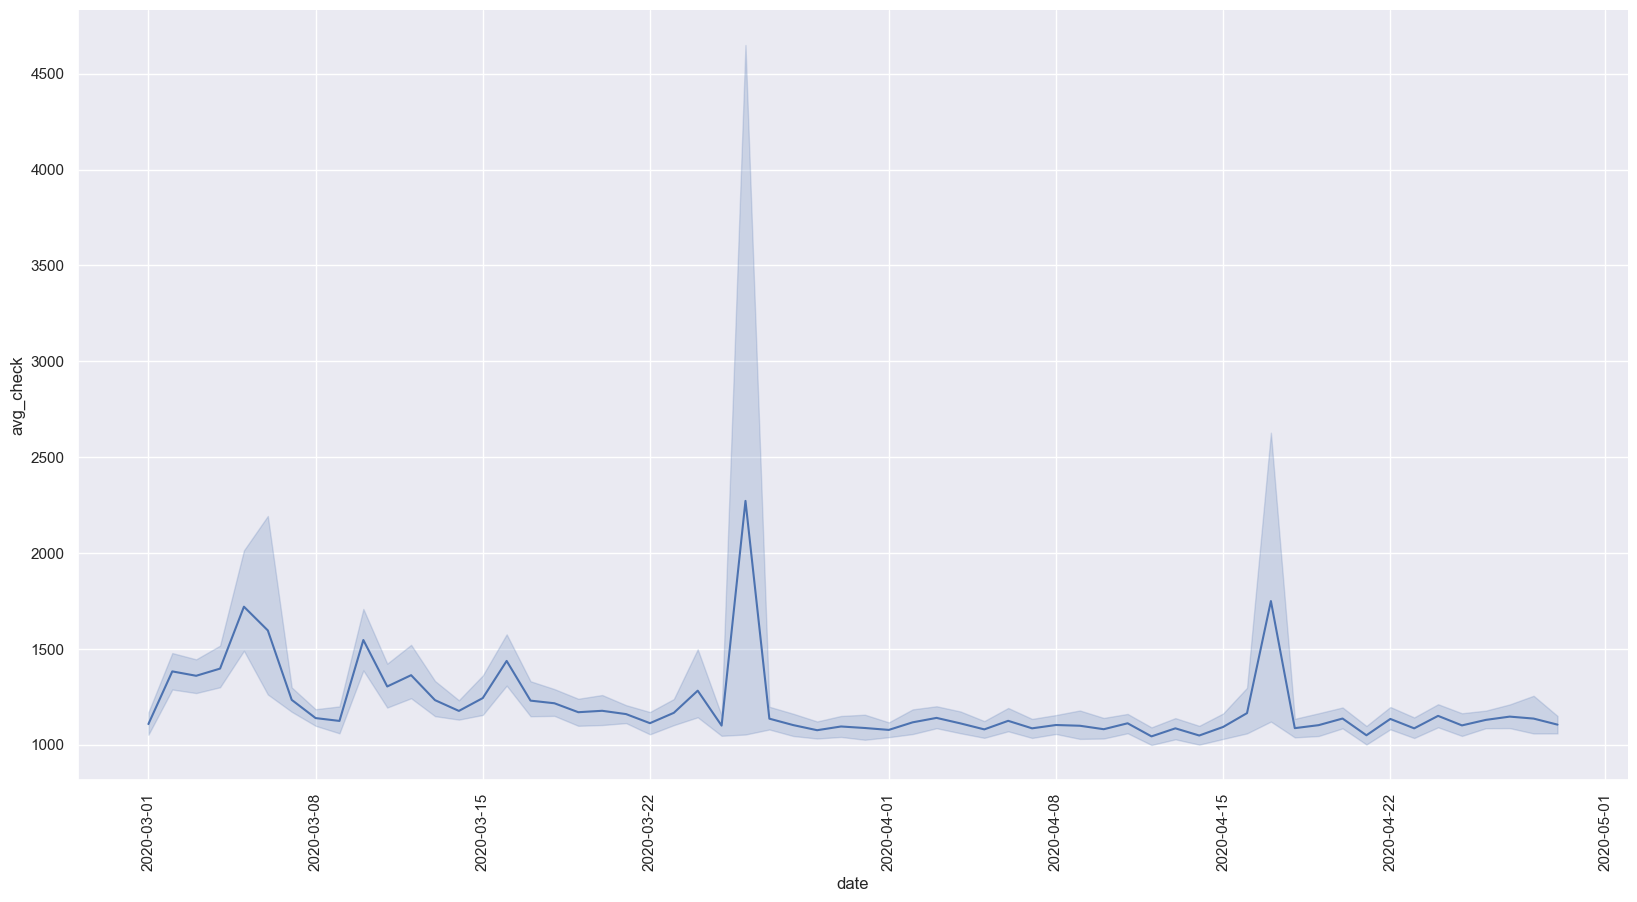

In [24]:
# построим график lineplot по марту и апрелю 2020

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_march_april)
sns.despine()

С конца марта по середину апреля заметен спад, скорее всего, это связано с тем, что ввелись первые серьёзные короновирусные ограничения.

В России подписали указ об объявлении в стране недели с 30 марта по 3 апреля нерабочей с сохранением за работниками зарплат.

https://ria.ru/20200330/1569328070.html

С 30 марта по 11 мая 2020 года в России действовал режим нерабочих дней с сохранением заработной платы. В этот период было приостановлено функционирование значительной части экономики, за исключением непрерывных производств, торговли продуктами питания, аптек; кафе и рестораны могли работать только навынос или доставкой.

https://tass.ru/info/15101389

In [25]:
# найдем заметные выбросы
# топ-5 дней по сумме среднего чека

df_2.sort_values('avg_check', ascending=False).head(5)

,source,date,promo_activated,transactions,revenue,avg_check
17144,(direct),2020-03-26,no,8,1258963.0,157370.375000
15159,google,2020-04-17,no,6,349088.0,58181.333333
17377,DuckDuckGo,2020-03-06,no,1,43956.0,43956.000000
12434,google,2020-04-17,no,5,206433.0,41286.600000
17589,yandex,2020-03-05,no,2,36267.0,18133.500000


26 марта 2020 года Россия полностью прекратила регулярное авиасообщение с другими странами.

https://tass.ru/info/15101389

05 марта 2020 Мэром Москвы был издан указ №12-УМ «О введении мер повышенной готовности», которым многим компаниям предписано было закрыться (рестораны, салоны красоты, бани…). Были также запрещены массовые мероприятия.

https://rg.ru/documents/2020/03/05/moscow-ukaz12-reg-dok.html

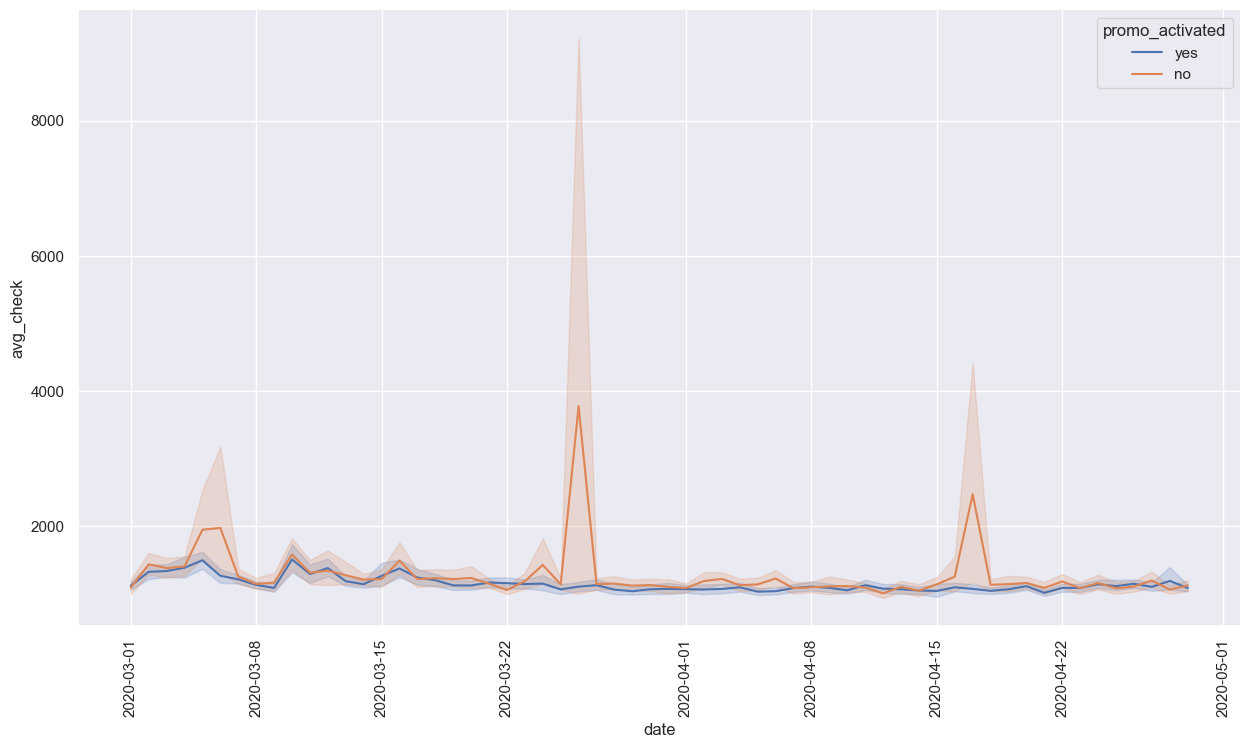

In [26]:
# построим график lineplot в зависимости от активации промокода

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_march_april, hue='promo_activated')
sns.despine()

In [27]:
# посмотрим поближе данные за март и апрель 2020 в зависимости от активации промокода

In [28]:
# c промокодом

df_2_promo_yes = df_march_april.query("promo_activated == 'yes'").query("date >= '2020-03-01' and date < '2020-04-30'")
df_2_promo_yes.head()

,source,date,promo_activated,transactions,revenue,avg_check
12,(direct),2020-03-26,yes,14,14488.0,1034.857143
13,(direct),2020-03-26,yes,95,97904.0,1030.568421
15,google,2020-03-26,yes,278,266796.0,959.697842
16,admitad,2020-03-26,yes,39,37693.0,966.487179
21,google,2020-03-26,yes,187,183640.0,982.032086


In [29]:
# без промокода

df_2_promo_no = df_march_april.query("promo_activated == 'no'").query("date >= '2020-03-01' and date < '2020-04-30'")
df_2_promo_no.head()

,source,date,promo_activated,transactions,revenue,avg_check
14,(direct),2020-03-26,no,37,34204.0,924.432432
17,google,2020-03-26,no,111,126956.0,1143.747748
18,yandex,2020-03-26,no,67,79068.0,1180.119403
19,google,2020-03-26,no,133,129656.0,974.857143
20,yandex,2020-03-26,no,102,99566.0,976.137255


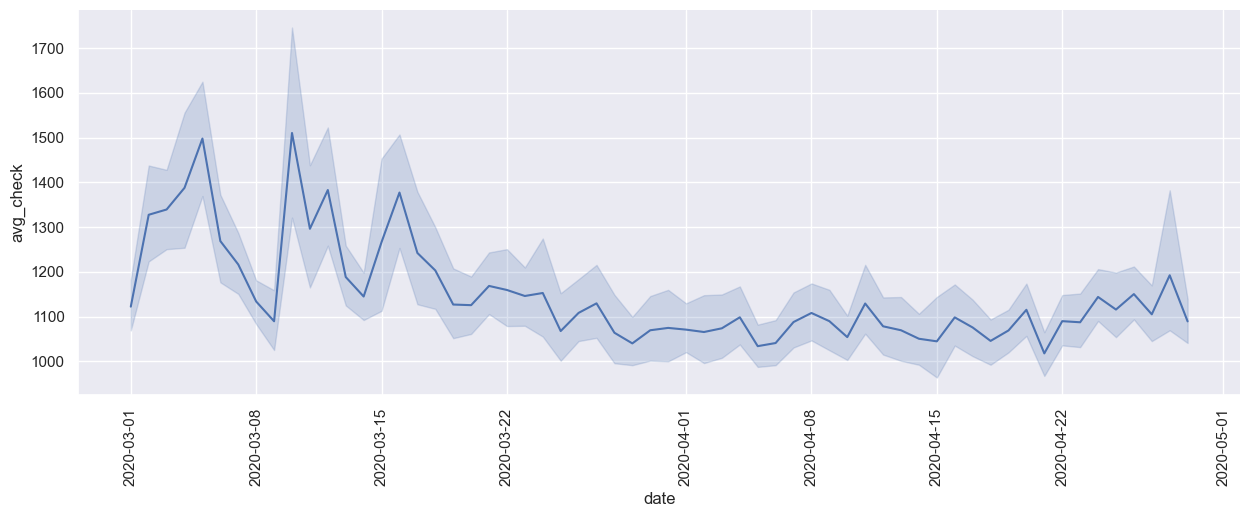

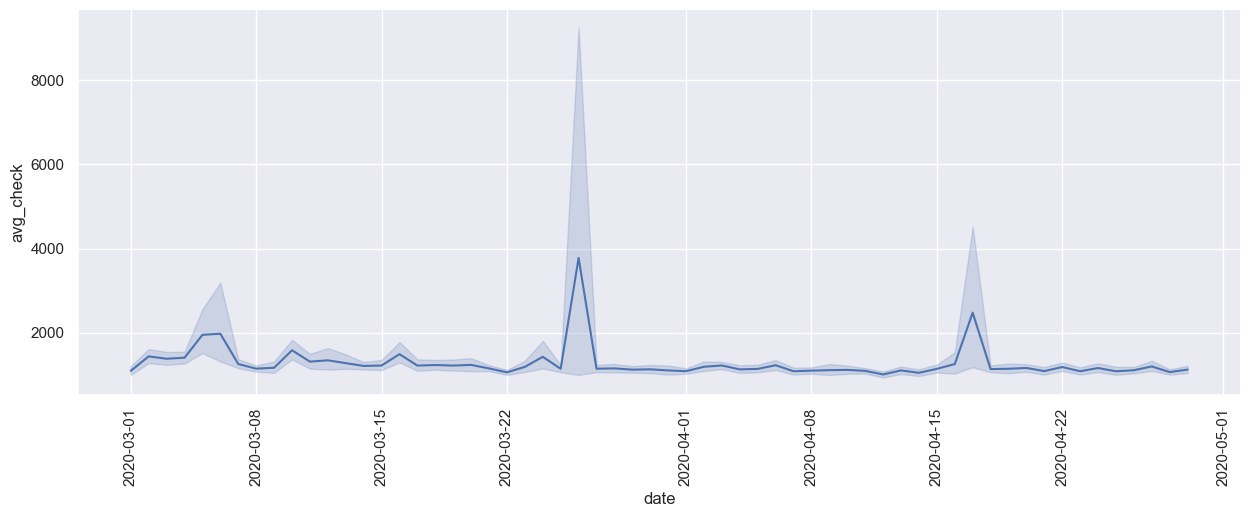

In [30]:
# построим график lineplot

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_2_promo_yes)
sns.despine()

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_2_promo_no)
sns.despine()

### 2 вариант.
Группировка по дате. Средний чек за день

In [31]:
df_mean = df_2.groupby('date').agg({'avg_check' : 'mean'}).reset_index()
df_mean

,date,avg_check
0,2020-01-01,1125.093281
1,2020-01-02,1151.822613
2,2020-01-03,1225.627378
3,2020-01-04,1199.836755
4,2020-01-05,1216.646850
...,...,...
269,2020-09-26,1267.512539
270,2020-09-27,1208.778296
271,2020-09-28,1333.060386
272,2020-09-29,1229.681171


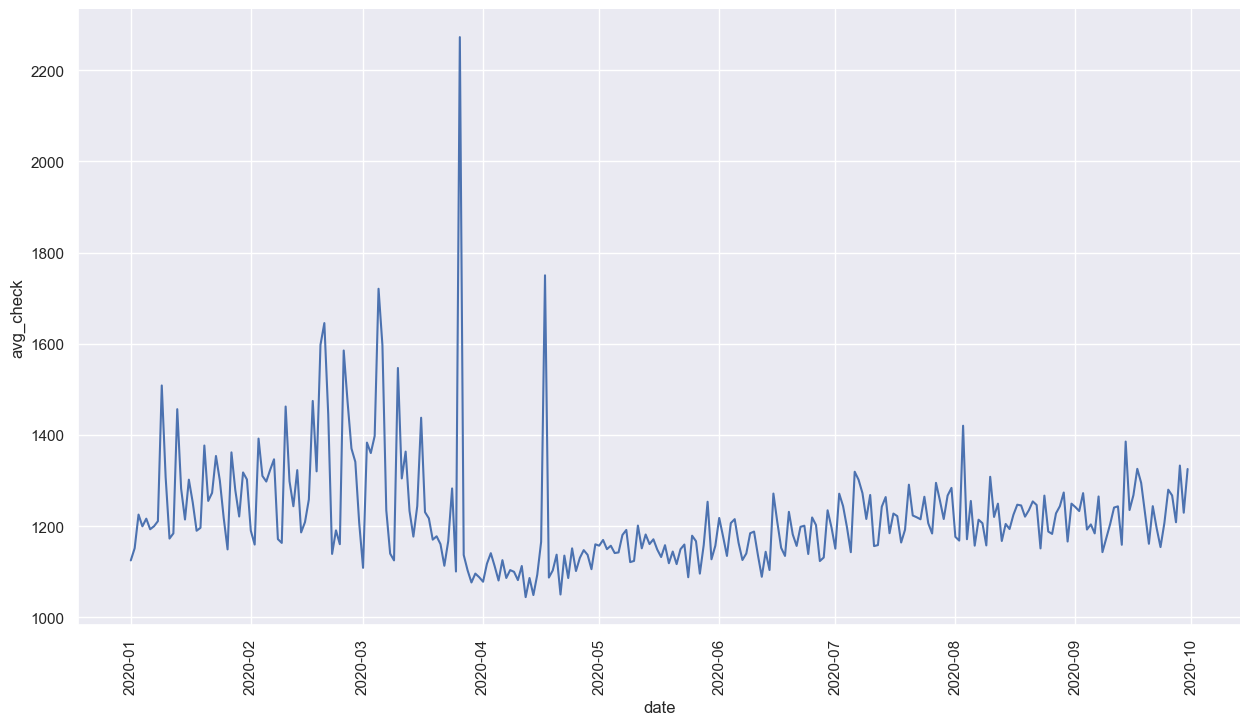

In [32]:
# построим график lineplot

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_mean)
sns.despine()

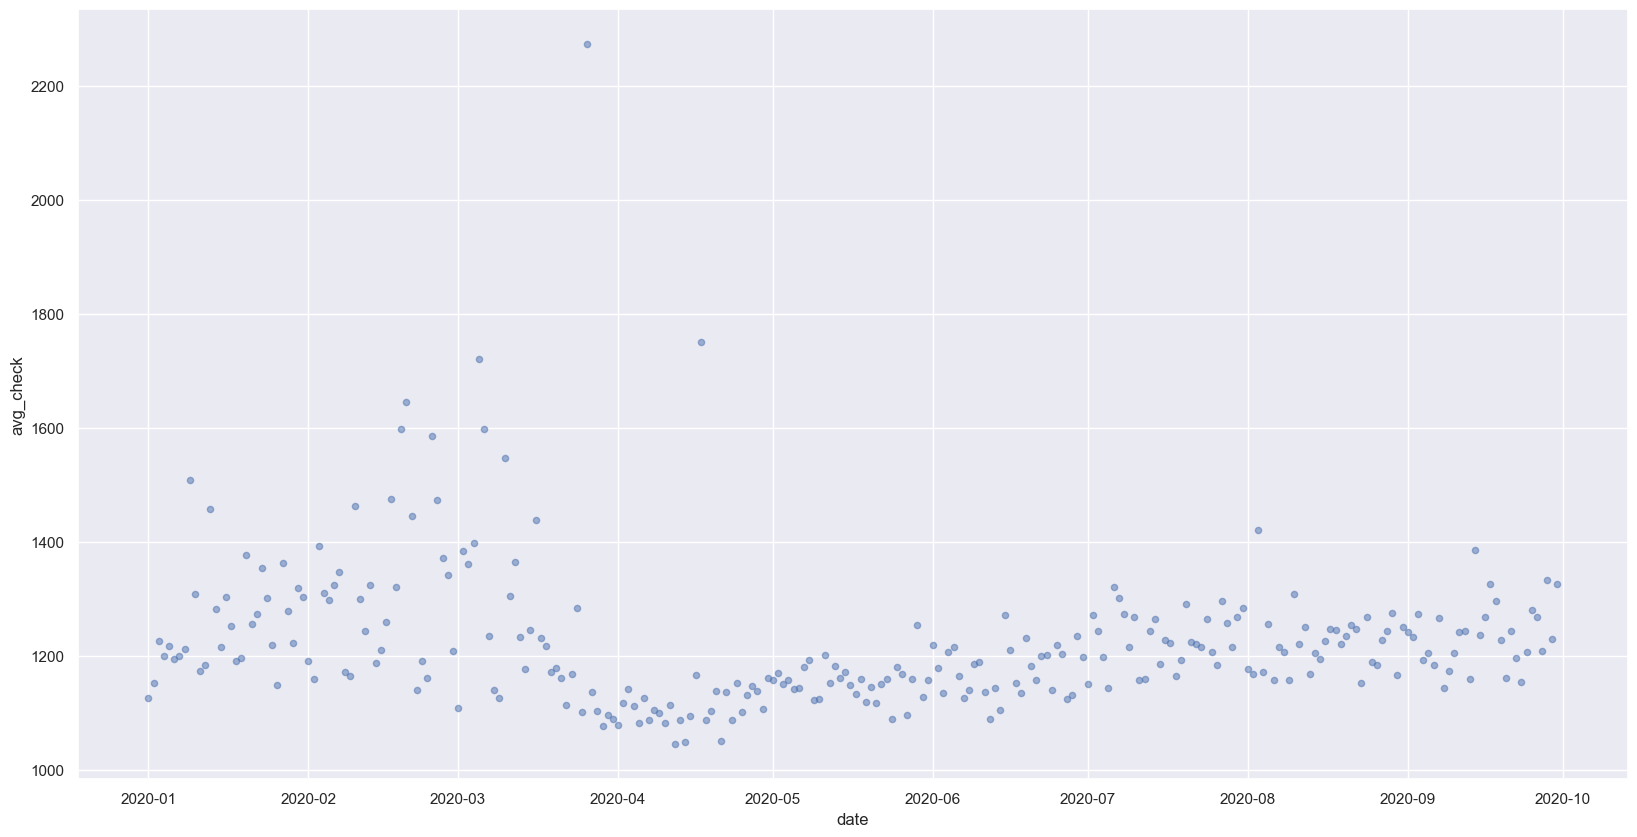

In [33]:
# посмотрим где есть выбросы

df_mean.plot.scatter(x="date", y="avg_check", alpha=0.5);

In [34]:
df_mean['promo_activated'] = df_2.promo_activated

In [35]:
df_mean

,date,avg_check,promo_activated
0,2020-01-01,1125.093281,no
1,2020-01-02,1151.822613,yes
2,2020-01-03,1225.627378,no
3,2020-01-04,1199.836755,no
4,2020-01-05,1216.646850,no
...,...,...,...
269,2020-09-26,1267.512539,yes
270,2020-09-27,1208.778296,no
271,2020-09-28,1333.060386,no
272,2020-09-29,1229.681171,no


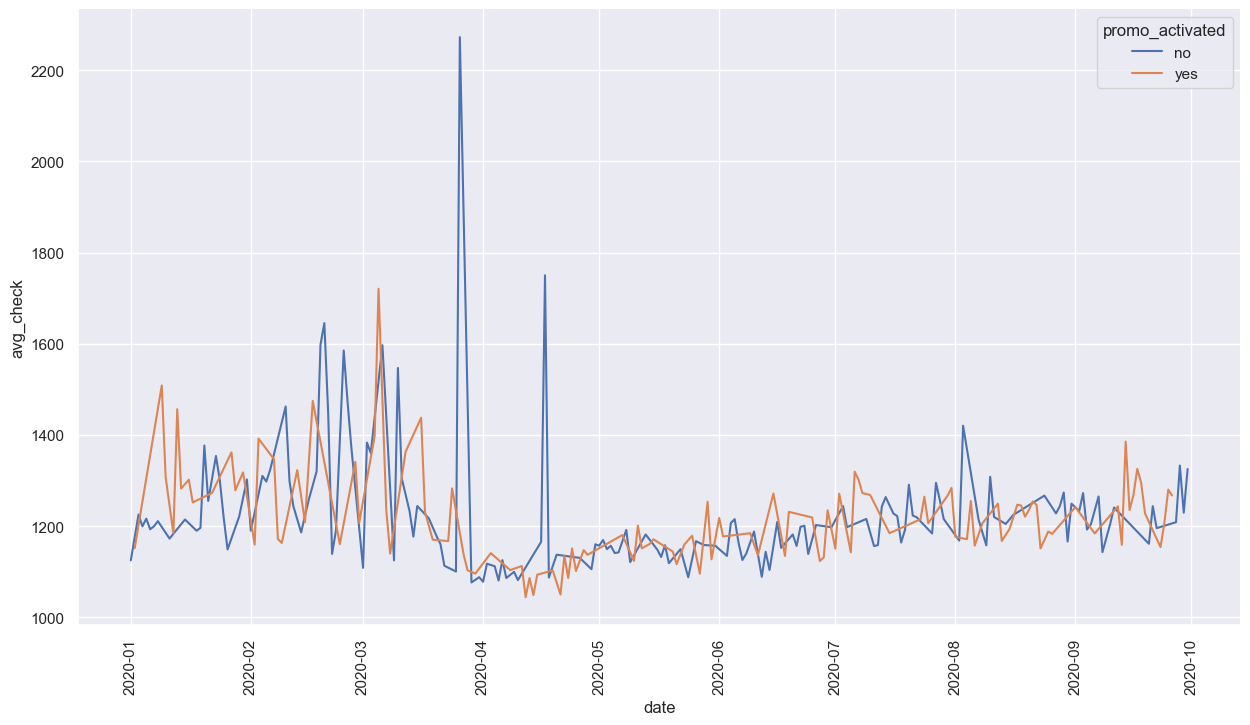

In [36]:
# построим график lineplot

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='avg_check', data=df_mean, hue='promo_activated')
sns.despine()

До короновирусных ограничений (февраль-март 2020) был рост среднего чека, а после (март-апрель 2020) снизился.

### c. Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?

Коэффициент конверсии (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей.

CR = (Количество целевых действий / Общее число посетителей) * 100 %

In [37]:
df.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0


In [38]:
df_new = df

In [39]:
df_new['cr'] = (df.transactions / df.visits) * 100
df_new.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,cr
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,7.299270
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,39.889706
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,6.896552
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,8.313817
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,6.200000


In [40]:
# добавим столбец со днями недели

df_new['day_of_the_week'] = df_new['date'].dt.day_name()
df_new.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,cr,day_of_the_week
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,7.299270,Monday
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,39.889706,Monday
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,6.896552,Monday
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,8.313817,Monday
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,6.200000,Monday


In [41]:
# данные в будни

df_weekdays = df_new.query("day_of_the_week == 'Monday'or \
                            day_of_the_week == 'Tuesday' or \
                            day_of_the_week == 'Wednesday' or \
                            day_of_the_week == 'Thursday' or \
                            day_of_the_week == 'Friday'")
df_weekdays

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,cr,day_of_the_week
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,7.299270,Monday
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,39.889706,Monday
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,6.896552,Monday
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,8.313817,Monday
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,6.200000,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52714,2020-08-06,yandex,organic,Доставка есть,Десктоп,yes,yes,133,8,250,50,47,5,4602.0,62.500000,Thursday
52715,2020-01-13,eLama,cpc,Доставка есть,Мобайл,no,no,70,8,250,48,36,8,6156.0,100.000000,Monday
52718,2020-09-22,google,cpc,Доставка есть,Мобайл,yes,yes,153,3,250,50,58,1,958.0,33.333333,Tuesday
52719,2020-08-25,(direct),(none),Не определено,Мобайл,yes,yes,219,8,250,50,45,1,828.0,12.500000,Tuesday


In [42]:
# данные в выходные

df_weekends = df_new.query("day_of_the_week == 'Saturday' or day_of_the_week == 'Sunday'")
df_weekends

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,cr,day_of_the_week
116,2020-02-29,google,organic,Не определено,Мобайл,no,no,8555,3808,15280,3052,1936,349,353611.0,9.164916,Saturday
117,2020-02-29,google,organic,Не определено,Мобайл,yes,no,3392,614,8840,1768,1498,224,253379.0,36.482085,Saturday
118,2020-02-29,(direct),(none),Не определено,Мобайл,yes,no,2037,392,5190,1036,709,114,128677.0,29.081633,Saturday
119,2020-02-29,admitad,cpa,Не определено,Мобайл,no,no,2272,1272,700,140,116,12,10656.0,0.943396,Saturday
120,2020-02-29,google,organic,Не определено,Десктоп,no,no,4043,1484,9240,1848,975,203,232532.0,13.679245,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52700,2020-02-29,admitad,cpa,Не определено,Десктоп,yes,yes,87,8,250,50,34,4,4914.0,50.000000,Saturday
52702,2020-02-08,google,cpc,Доставка есть,Мобайл,yes,yes,94,5,250,50,22,3,4037.0,60.000000,Saturday
52706,2020-02-22,yandex,organic,Доставка есть,Мобайл,yes,yes,96,4,250,50,19,4,5468.0,100.000000,Saturday
52716,2020-06-21,(direct),(none),Доставка есть,Мобайл,yes,yes,65,4,250,50,58,4,4821.0,100.000000,Sunday


In [43]:
# средний СR по дням недели

df_new_day = df_new.groupby('day_of_the_week') \
                .agg({'cr' : 'mean'}) \
                .reset_index() \
                .sort_values('day_of_the_week')
df_new_day

,day_of_the_week,cr
0,Friday,39.556530
1,Monday,36.685853
2,Saturday,40.539692
3,Sunday,39.469669
4,Thursday,37.682041
5,Tuesday,36.805079
6,Wednesday,37.234120


In [44]:
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=cats, ordered=True)

In [45]:
df_new_day['day_of_the_week'] = df_new_day['day_of_the_week'].astype(cat_type)
df_new_day.dtypes

day_of_the_week    category
cr                  float64
dtype: object

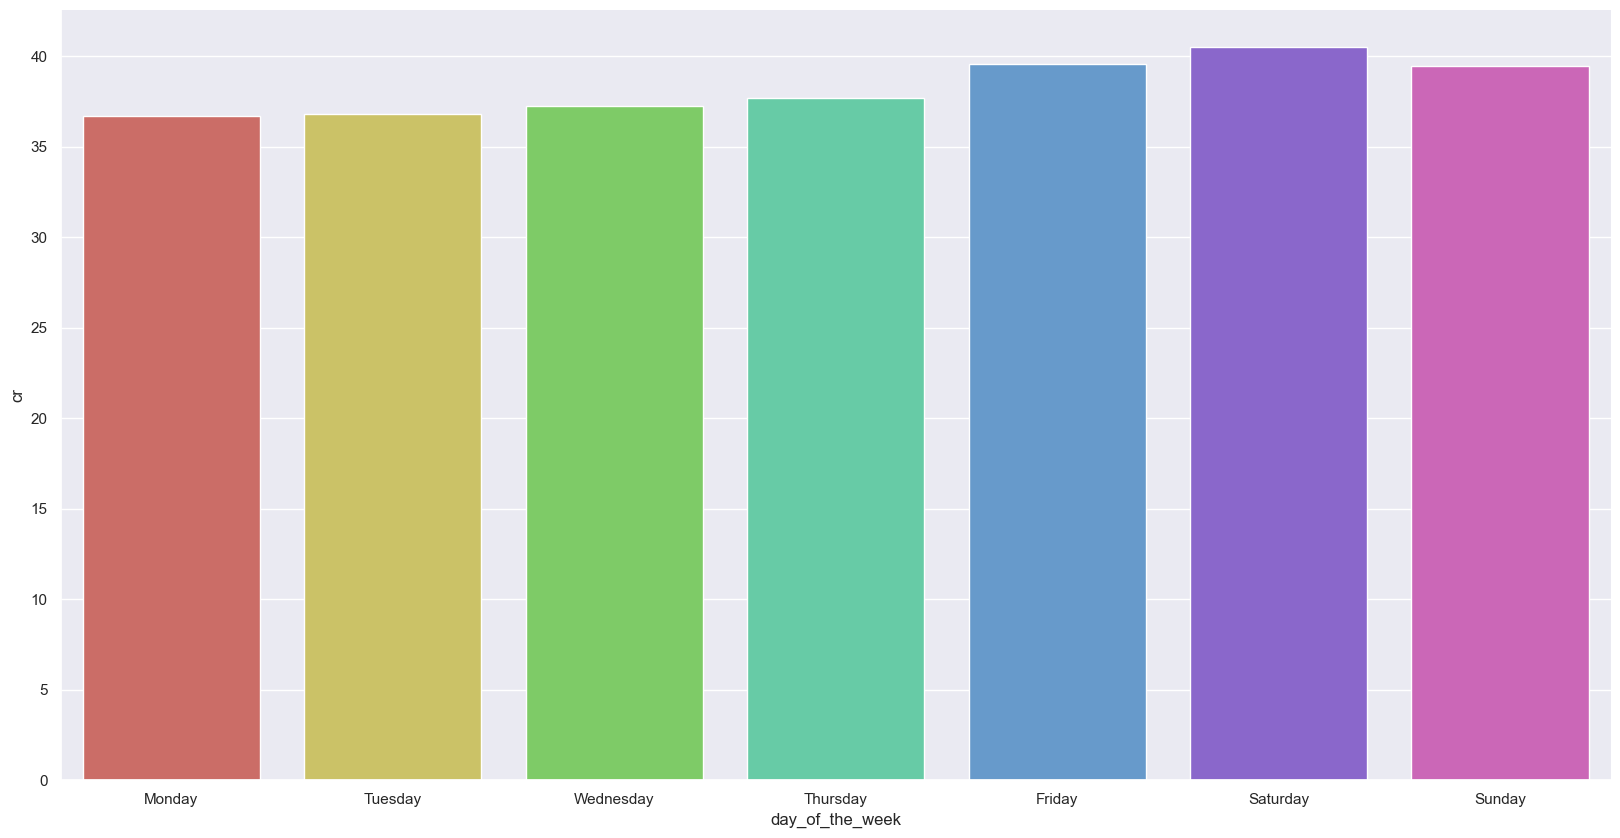

In [46]:
# средний CR по дням недели

sns.barplot(x=df_new_day['day_of_the_week'],y=df_new_day['cr'],data=df_new_day,palette='hls')
sns.despine()
sns.set(rc={'figure.figsize':(15,5)})

На графике наглядно понятно, что CR растет ближе к выходным

In [47]:
# средний CR по будням

round(df_weekdays.cr.mean(),2)

37.63

In [48]:
# средний CR по выходным

round(df_weekends.cr.mean(),2)

40.01

Средняя конверсия в будни дни: **37.63 %**
    
Средняя конверсия в выходные дни: **40.01 %**

**Сформируем гипотезы:**

Нулевая гипотеза:

H0 = CR в выходные дни не отличается от CR в будние дни;

Альтернативная гипотеза:

H1 = CR в выходные дни отличается от CR в будние дни.

In [73]:
df_weekdays.cr.var()

1489.6795685833747

In [74]:
df_weekends.cr.var()

1456.174629891153

In [75]:
# Проверка нулевой и альтернативной гипотезы 

sample_1 = df_weekdays['cr']
sample_2 = df_weekends['cr']

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 7.476651926325496e-11
Отвергаем нулевую гипотезу


ОТВЕТ:

С уверенностью в 95% можно сказать, что CR в выходные дни статистически значимо отличается от CR в будние дни

### d. Вам необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. 
### Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?

Проделано:

1. Первичный анализ данных
2. Визуализация временного ряда
3. Анализ тренда, сезонности, остатков

Далее я бы подошла к задаче следующим образом, но в данном случае просто опишу последующие действия:

4. Подготовка новых признаков
5. Выборки
6. Обучение и тестирование моделей

In [51]:
df.head()

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,cr,day_of_the_week
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0,7.299270,Monday
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,39.889706,Monday
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,6.896552,Monday
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,8.313817,Monday
4,2020-05-11,yandex,organic,Не определено,Десктоп,no,no,2159,1000,4110,824,351,62,61861.0,6.200000,Monday


In [76]:
df_medium = df.query("medium == 'cpc'")
df_medium

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue,cr,day_of_the_week
1,2020-05-11,yandex,cpc,Не определено,Мобайл,yes,no,3302,544,9930,1984,1416,217,244478.0,39.889706,Monday
2,2020-05-11,google,cpc,Не определено,Мобайл,no,no,2970,1450,5460,1090,599,100,105150.0,6.896552,Monday
3,2020-05-11,google,cpc,Не определено,Десктоп,no,no,1875,854,4250,848,407,71,79003.0,8.313817,Monday
5,2020-05-11,yandex,cpc,Не определено,Десктоп,no,no,2775,1441,5990,1196,549,76,90862.0,5.274115,Monday
7,2020-05-11,yandex,cpc,Не определено,Мобайл,no,no,3854,1842,7310,1462,913,150,168397.0,8.143322,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52705,2020-04-07,google,cpc,Доставка есть,Десктоп,yes,yes,85,3,250,50,12,3,3377.0,100.000000,Tuesday
52707,2020-06-02,yandex,cpc,Доставки нет,Десктоп,yes,no,83,7,250,50,48,4,6089.0,57.142857,Tuesday
52710,2020-09-07,yandex,cpc,Доставки нет,Мобайл,yes,no,165,5,250,50,39,3,5689.0,60.000000,Monday
52715,2020-01-13,eLama,cpc,Доставка есть,Мобайл,no,no,70,8,250,48,36,8,6156.0,100.000000,Monday


In [80]:
cpc_revenue = df_medium['revenue'].mean()
cpc_revenue

26426.51981227351

In [130]:
cpc_revenue = df_medium.groupby('date').agg({'revenue' : 'mean'})#.reset_index()
cpc_revenue

,revenue
date,
2020-01-01,24129.471698
2020-01-02,32854.370370
2020-01-03,33734.142857
2020-01-04,30931.761194
2020-01-05,34363.900000
...,...
2020-09-26,21439.833333
2020-09-27,18797.076923
2020-09-28,11434.305556


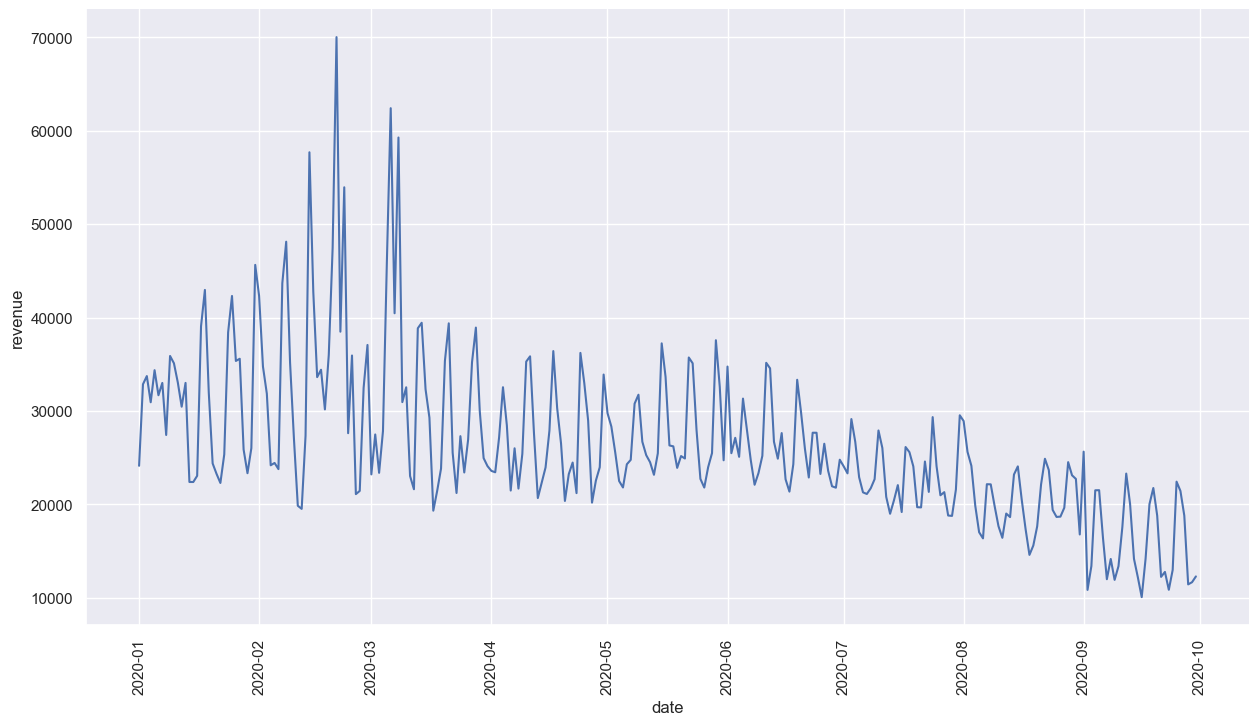

In [131]:
# построим график lineplot
# посмотрим на график дохода, полученного с пользователей, приведенных на сайт контекстной рекламой

plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
sns.lineplot(x='date', y='revenue', data=cpc_revenue)
sns.despine()

In [99]:
#cpc_revenue['mean'] = cpc_revenue['revenue'].rolling(10).mean()
#cpc_revenue['std'] = cpc_revenue['revenue'].rolling(10).std()

До короновирусных ограничений (февраль-март 2020) был рост дохода после (март-апрель 2020) доход постепенно снижался.

Используем функцию 'seasonal_decompose()', которая раскладывает временной ряд на тренд, сезонность и остаток.

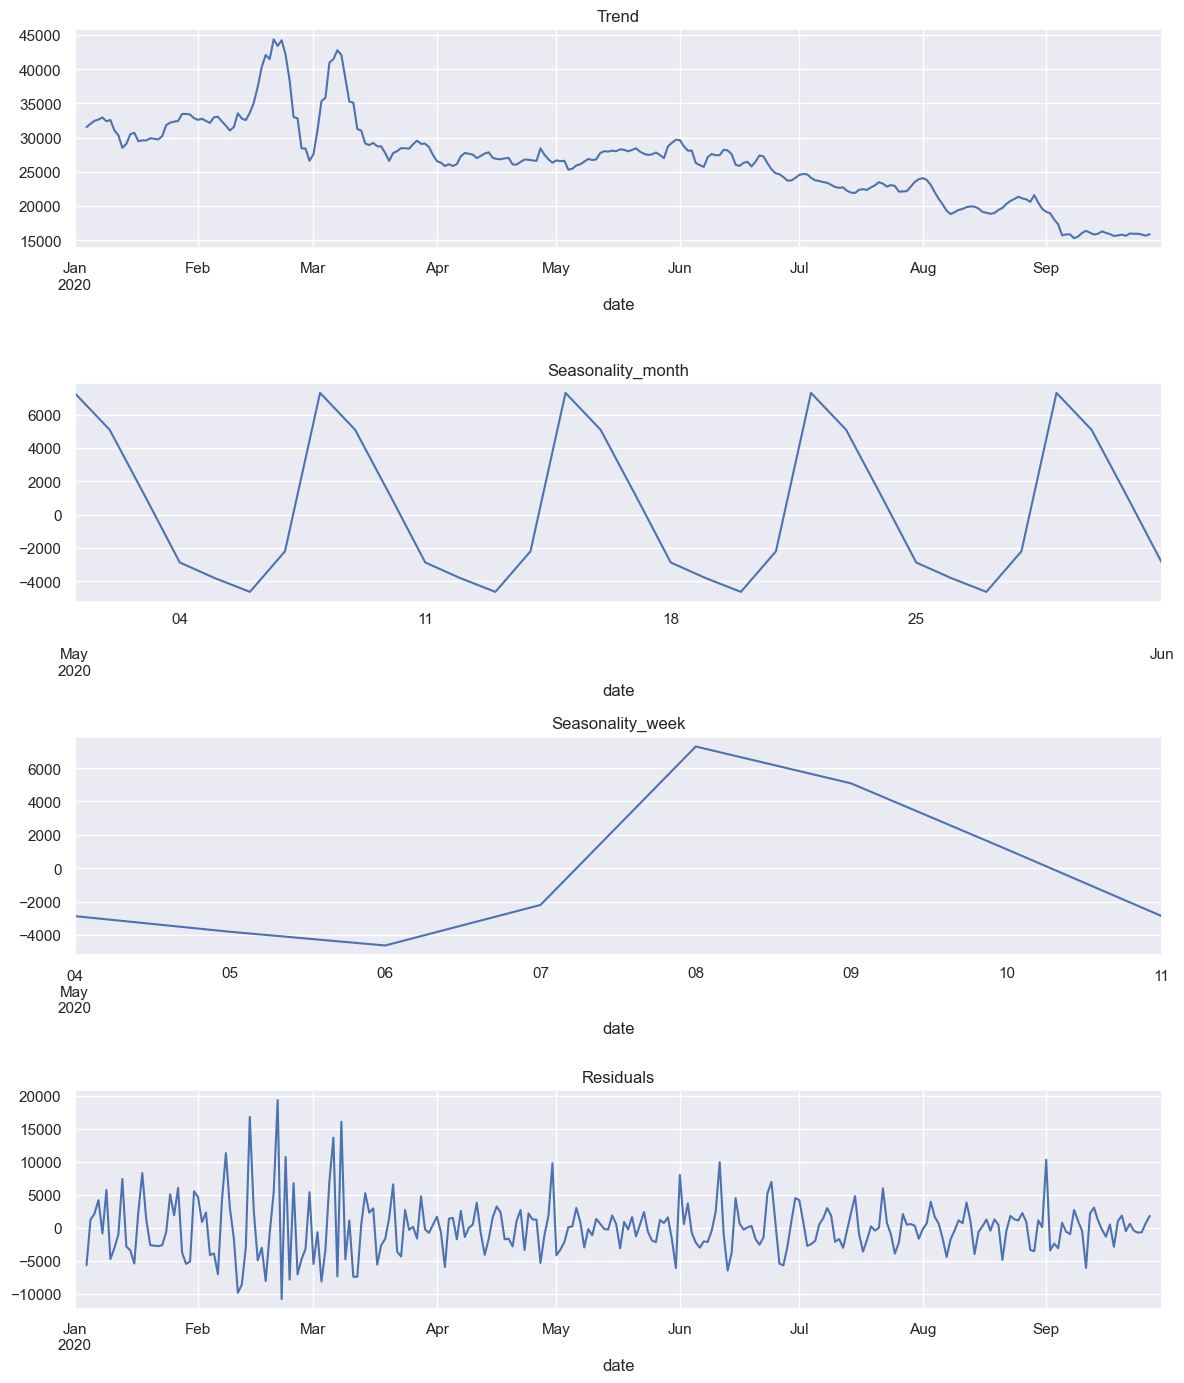

In [132]:
decomposed = seasonal_decompose(cpc_revenue)
plt.figure(figsize=(12, 14))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(412)
decomposed.seasonal['2020-05-01':'2020-06-01'].plot(ax=plt.gca())
plt.title('Seasonality_month')

plt.subplot(413)
decomposed.seasonal['2020-05-04':'2020-05-11'].plot(ax=plt.gca())
plt.title('Seasonality_week')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

По графику "Trend" видно, что максимальный рост дохода в конце февраля - начало марта 2020 (период до коронавирусных ограничений), после доход постепенно снижался.

По графику "Seasonality_month" видно, что объем дохода, полученный с пользователей, приведенных на сайт контекстной рекламой, зависит от дня недели и циклично повторяется.

По графику "Seasonality_week" видно, что минимум в среду, максимум - в пятницу и субботу

В реальности бизнеса есть все три вида сезонности:

1. Дневная сезонность - данные собраны по дням, т.е. будни и выходные имеют разные продажи.
2. Внутрисуточная сезонность: когда продажи утром отличаются от продаж.
3. Вечером месячная сезонность: когда продажи лета и осени - разные.

Если строить прогноз на длительный период времени, то без учёта всех видов сезонности не обойтись. Например, если в данных восходящий тренд, то возникает: этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезонности?

Т.к. у нас есть данные только за 9 месяцев не получится достаточно точно спрогнозировать доход на 6 месяцев. Нужно больше данных для более корректного анализа.